<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>Egg Sales Forecasting</center></h1>

## **Introduction**

Hello, I'm Teja Srinivas, a Data Science and Machine Learning Enthusiast. I'm currently pursuing my B.Tech in Computer Science and Engineering. I found [this dataset on Kaggle](https://www.kaggle.com/datasets/kanchana1990/egg-sales-of-a-local-shop-for-30-years/data) and I thought it would be a good idea to try and forecast the sales of eggs. I'm still a beginner in this field and I'm trying to learn as much as I can. I hope you like my work and please do leave a comment if you have any suggestions or feedback. Thank you!
## **Problem Statement**
Dive into the world of time series forecasting with the Egg Sales Forecasting Challenge! This competition provides a rich dataset detailing 30 years of egg sales from a Sri Lankan shop. As participants, you'll uncover the nuances of seasonal fluctuations influenced by cultural festivities, global events, and even unexpected lockdowns. Beyond just raw numbers, this dataset tells a story of traditions, market dynamics, and the resilience of businesses. Your mission? Harness this wealth of information to predict the egg sales for 2022. Whether you're a newbie in forecasting or a seasoned data scientist, this challenge offers a unique opportunity to hone your skills.

### **Table of Contents**
* [1. Importing Libraries and Loading the Dataset](#1)
---
* [2. Data Preprocessing](#2)
    * [2.1. Checking for Missing Values](#2.1)
    * [2.2. Checking for Outliers using IQR](#2.2)
    * [2.3. Adding Columns for Year, Month and Day](#2.3)
---
* [3. Exploratory Data Analysis](#3)
    * [3.1. Statistical Summary](#3.1)
    * [3.2. Heatmap](#3.2)
    * [3.3. Sales Across Years](#3.3)
    * [3.4. Monthly Sales arranged by Year](#3.4)
---


* [4. Data Preparation](#4)
    * [4.1. Checking for Stationarity](#4.1)
    * [4.2. Making the Data Stationary](#4.2)
    * [4.3. Plotting ACF and PACF](#4.3)
    * [4.4. Tuning the Parameters for SARIMA](#4.4)
---
* [5. Model Building and Evaluation](#5)
---
* [6. Forecasting Sales](#6)
    * [6.1. Loading Test Data](#6.1)
---
* [7. Conclusion](#7)
---
* [8. References](#8)

## 1. Importing Libraries and Loading the Dataset <a class="anchor" id="1"></a>

In [3]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error

import itertools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from math import sqrt

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('./data/train_egg_sales.csv', sep=';')
train.head(5)

,Date,Egg Sales
0,1993-01-01,91
1,1993-01-02,124
2,1993-01-03,112
3,1993-01-04,115
4,1993-01-05,107


## 2. Data Preprocessing <a class="anchor" id="2"></a>

* Converting **Date** column to **datetime** format

In [ ]:
train['Date'] = pd.to_datetime(train['Date'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10592 entries, 0 to 10591
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10592 non-null  datetime64[ns]
 1   Egg Sales  10592 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 165.6 KB


### 2.1. Checking for Missing Values <a class="anchor" id="2.1"></a>

In [ ]:
train.isna().sum()

Date         0
Egg Sales    0
dtype: int64

Luckily, there are no missing values in the dataset.

### 2.2. Checking for Outliers using IQR (Inter Quartile Range) <a class="anchor" id="2.2"></a>

In [ ]:
# IQR for Sales
Q1 = train['Egg Sales'].quantile(0.25)
Q3 = train['Egg Sales'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
outliers = (train['Egg Sales'] < (Q1 - 1.5 * IQR)
            ) | (train['Egg Sales'] > (Q3 + 1.5 * IQR))
print(outliers.value_counts())

264.0
False    10592
Name: Egg Sales, dtype: int64


There are no outliers for **Sales** Column.

### 2.3. Adding Columns for Year, Month and Day <a class="anchor" id="2.3"></a>

In [ ]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.isocalendar().week
train['DayOfWeek'] = train['Date'].dt.dayofweek
# Renaming Egg Sales column to Sales
train.columns = ['Date', 'Sales', 'Year',
                 'Month', 'Day', 'WeekOfYear', 'DayOfWeek']

In [ ]:
train.describe()

,Sales,Year,Month,Day,WeekOfYear,DayOfWeek
count,10592.000000,10592.000000,10592.000000,10592.000000,10592.0,10592.000000
mean,366.326095,2007.000661,6.523036,15.729324,26.590257,3.000094
std,155.202620,8.366798,3.448837,8.800375,15.063012,2.000024
min,0.000000,1993.000000,1.000000,1.000000,1.0,0.000000
25%,235.000000,2000.000000,4.000000,8.000000,14.0,1.000000
50%,366.000000,2007.000000,7.000000,16.000000,27.0,3.000000
75%,499.000000,2014.000000,10.000000,23.000000,40.0,5.000000
max,713.000000,2021.000000,12.000000,31.000000,53.0,6.000000


## 3. Exploratory Data Analysis <a class="anchor" id="3"></a>

### 3.1. Statistical Summary <a class="anchor" id="3.1"></a>

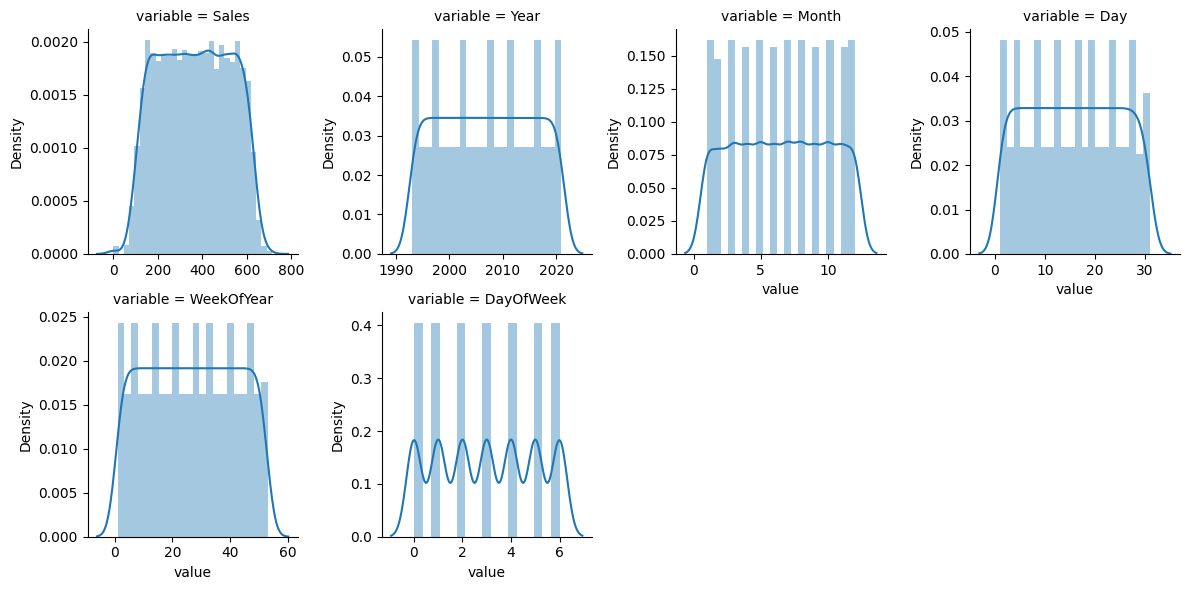

In [ ]:
df = pd.DataFrame(data=train, columns=[
                  'Sales', 'Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek'])
nd = pd.melt(df, value_vars=df)
n1 = sns.FacetGrid(nd, col='variable', col_wrap=4, sharex=False, sharey=False)
n1 = n1.map(sns.distplot, 'value')
n1

### 3.2. Heatmap <a class="anchor" id="3.2"></a>

<Axes: >

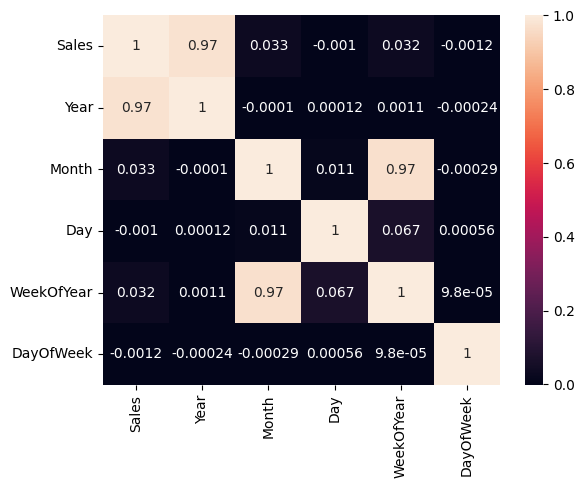

In [ ]:
sns.heatmap(train.corr(), annot=True)

### 3.3 Sales Across Years <a class="anchor" id="3.3"></a>

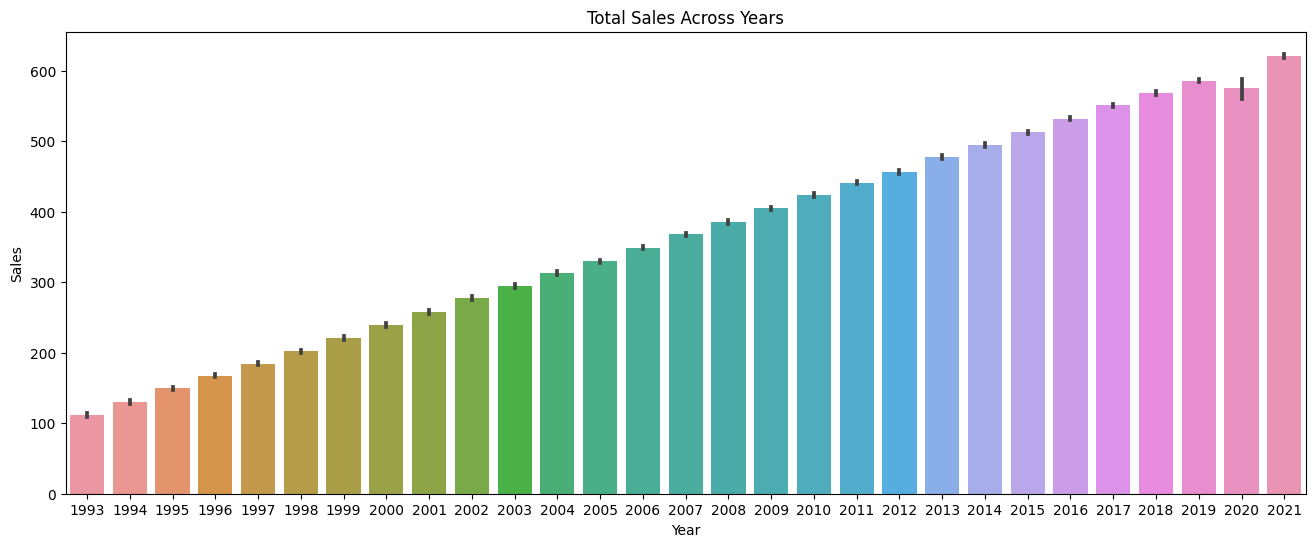

In [ ]:
# Total Sales Across Years
plt.figure(figsize=(16, 6))
plt.title('Total Sales Across Years')
sns.barplot(x='Year', y='Sales', data=train)
plt.show()

### 3.4 Monthly Sales arranged by Year <a class="anchor" id="3.4"></a>

In [ ]:
# Setting Date as index
train = train.set_index('Date')

<Axes: title={'center': 'Monthly Sales arranged by Year'}, xlabel='Date'>

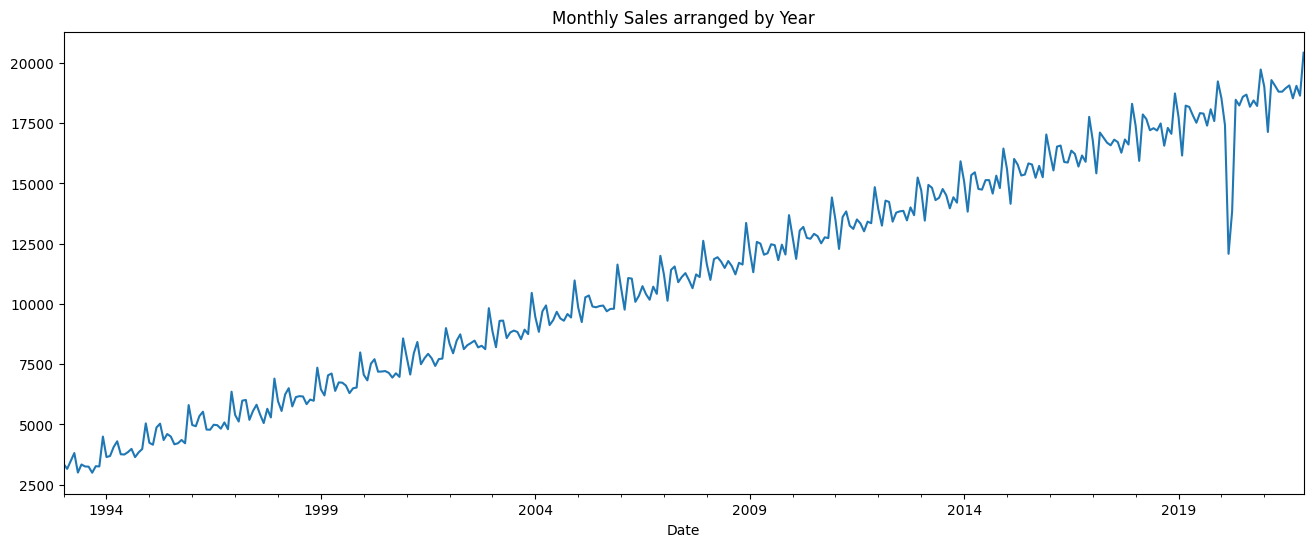

In [ ]:
train['Sales'].resample('m').sum().plot(
    title='Monthly Sales arranged by Year', figsize=(16, 6))

## 4. Data Preparation <a class="anchor" id="4"></a>

In [ ]:
train['Sales'] = train['Sales'] * 1.0

### 4.1. Checking for Stationarity <a class="anchor" id="4.1"></a>

In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time.
I'm using **Dicky - Fuller test** to test for stationarity of the data.

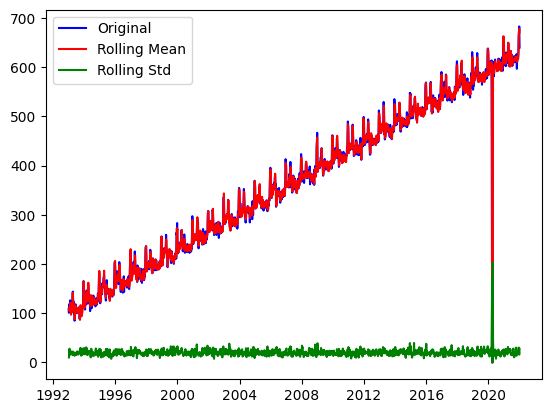

Results of Dickey-Fuller Test:
ADF Statistic: -1.609080
p-value: 0.479031
Critical Values:
1% -3.430969695978145
5% -2.8618138703454576
10% -2.5669157760426144


In [ ]:
def test_stationarity(timeseries):

    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(),
                    color='blue', label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(),
                    color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(),
                   color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)


test_stationarity(train['Sales'])

Here, the null hypothesis is that the data is non-stationary. If the p-value is less than 0.05, we can reject the null hypothesis and say that the data is stationary.

In [ ]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value',
              '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


adfuller_test(train['Sales'])

ADF Test Statistic : -1.6090802361032763
p-value : 0.47903077066857985
#Lags Used : 36
Number of Observations Used : 10555
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Since the **p-value** is not less than **0.05**, we can say that the data is non-stationary.

### 4.2. Making the Data Stationary <a class="anchor" id="4.2"></a>

We can make the data stationary by differencing the data. We can take the difference between the current value and the previous value. It depends on seasonality of the data. Here, the data is seasonal and hence we take the difference between the current value and the value from 15 days ago.

In [ ]:
difference = 15

In [ ]:
train['Difference'] = train['Sales'] - train['Sales'].shift(difference)

Testing for stationarity again, we can see that the **p-value** is less than **0.05** and hence we can say that the data is stationary.

In [ ]:
adfuller_test(train['Difference'].dropna())

ADF Test Statistic : -21.15500581399874
p-value : 0.0
#Lags Used : 38
Number of Observations Used : 10538
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


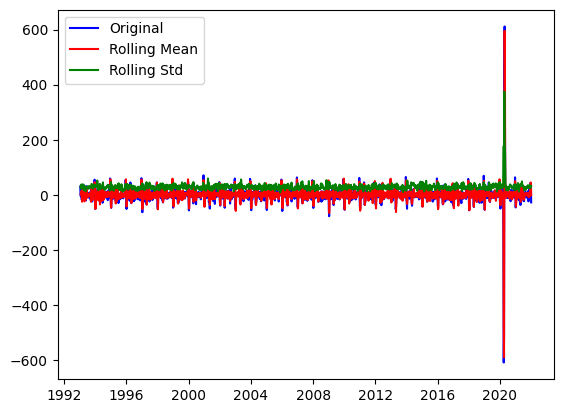

Results of Dickey-Fuller Test:
ADF Statistic: -21.155006
p-value: 0.000000
Critical Values:
1% -3.4309706959211588
5% -2.861814312217174
10% -2.566916011250628


In [ ]:
test_stationarity(train['Difference'].dropna())

### 4.3. Plotting ACF and PACF <a class="anchor" id="4.3"></a>

In order to use this model, we need to first find out values of p, d and q.
- p represents number of Autoregressive terms - lags of dependent variable.
- q represents number of Moving Average terms - lagged forecast errors in prediction equation.
- d represents number of non-seasonal differences.

To find the values of p, d and q - we use Autocorrelation function (ACF) and Partial Autocorrelation (PACF) plots.

- ACF - measure of correlation between time series with a lagged version of itself.
- PACF - measure of correlation between time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparison.

- p value is the value on x-axis of PACF where the plot crosses the upper Confidence Interval for the first time.
- q value is the value on x-axis of ACF where the plot crosses the upper Confidence Interval for the first time.


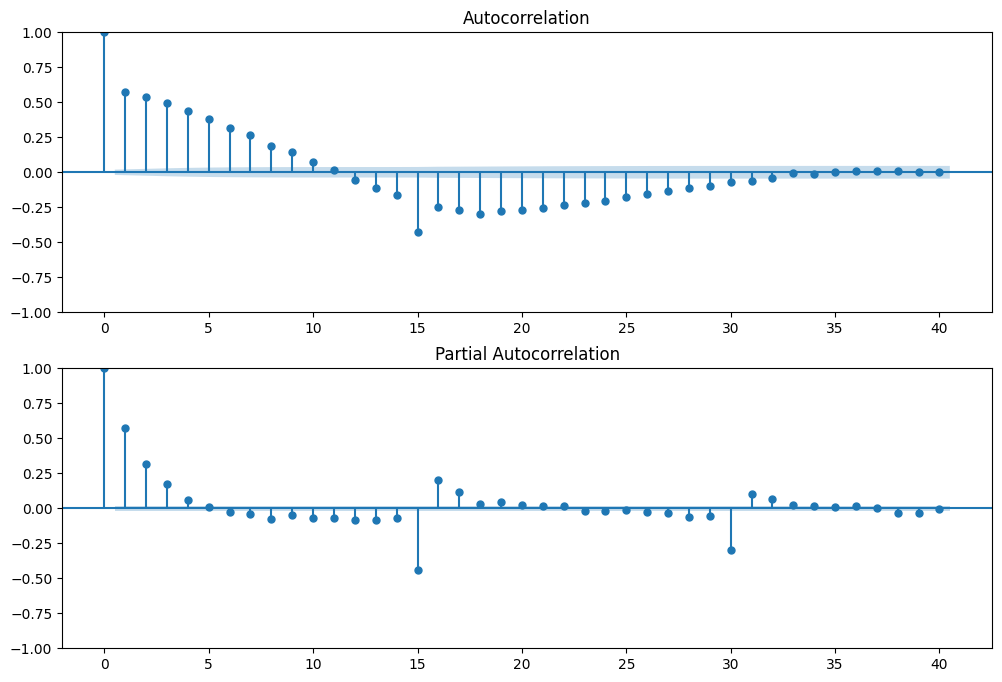

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train['Difference'].iloc[difference:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train['Difference'].iloc[difference:], lags=40, ax=ax2)

In [ ]:
train_arima = train['Sales']

### 4.4. Tuning the Parameters for SARIMA <a class="anchor" id="4.4"></a>

Instead of finding p, d and q separately, we can do a grid search and find the best combination of p, d and q, which gives the lowest Akaike Information Criterion (AIC). Best model uses the lowest number of features to fit the data.

In [ ]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], difference)
                for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 15)
SARIMAX: (0, 0, 1) x (0, 1, 0, 15)
SARIMAX: (0, 1, 0) x (0, 1, 1, 15)
SARIMAX: (0, 1, 0) x (1, 0, 0, 15)


In [ ]:
dictionary = {}

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}{} - AIC:{}'.format(param,
                  param_seasonal, difference, results.aic))
            dictionary[(param, param_seasonal)] = results.aic
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 15)15 - AIC:156855.66199701224
ARIMA(0, 0, 0)x(0, 0, 1, 15)15 - AIC:144155.03995718312
ARIMA(0, 0, 0)x(0, 1, 0, 15)15 - AIC:111082.54542203023
ARIMA(0, 0, 0)x(0, 1, 1, 15)15 - AIC:106135.27637072533
ARIMA(0, 0, 0)x(1, 0, 0, 15)15 - AIC:111078.47649232374
ARIMA(0, 0, 0)x(1, 0, 1, 15)15 - AIC:106420.26118401103
ARIMA(0, 0, 0)x(1, 1, 0, 15)15 - AIC:108857.2461168845
ARIMA(0, 0, 0)x(1, 1, 1, 15)15 - AIC:106014.53064762092
ARIMA(0, 0, 1)x(0, 0, 0, 15)15 - AIC:143623.89552353902
ARIMA(0, 0, 1)x(0, 0, 1, 15)15 - AIC:134126.7886872414
ARIMA(0, 0, 1)x(0, 1, 0, 15)15 - AIC:108617.30032506368
ARIMA(0, 0, 1)x(0, 1, 1, 15)15 - AIC:103009.33861079467
ARIMA(0, 0, 1)x(1, 0, 0, 15)15 - AIC:108605.45119681756
ARIMA(0, 0, 1)x(1, 0, 1, 15)15 - AIC:102831.92481493417
ARIMA(0, 0, 1)x(1, 1, 0, 15)15 - AIC:106040.02390769086
ARIMA(0, 0, 1)x(1, 1, 1, 15)15 - AIC:102972.82979986051
ARIMA(0, 1, 0)x(0, 0, 0, 15)15 - AIC:102118.19745114553
ARIMA(0, 1, 0)x(0, 0, 1, 15)15 - AIC:101974.911698

Finding the best combination of pdq

In [ ]:
sorted_dict = dict(sorted(dictionary.items(), key=lambda item: item[1]))
first_key = next(iter(sorted_dict))

In [ ]:
pdq = first_key[0]
seasonal_order = first_key[1]

## 5. Model Building and Evaluation <a class="anchor" id="5"></a>

We're using SARIMA model to forecast the sales of eggs. SARIMA stands for Seasonal Autoregressive Integrated Moving Average. It is an extension of ARIMA model with an additional seasonal component.

### 5.1. Model Fitting <a class="anchor" id="5.1"></a>

Use the resultant pdq values to fit the model

In [ ]:
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                         order=pdq,
                                         seasonal_order=seasonal_order,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9658      0.001    816.999      0.000       0.963       0.968
ma.L1         -0.6038      0.002   -308.912      0.000      -0.608      -0.600
ar.S.L15      -0.0260      0.008     -3.093      0.002      -0.042      -0.010
ma.S.L15      -0.9709      0.003   -376.015      0.000      -0.976      -0.966
sigma2       641.1903      1.987    322.747      0.000     637.296     645.084


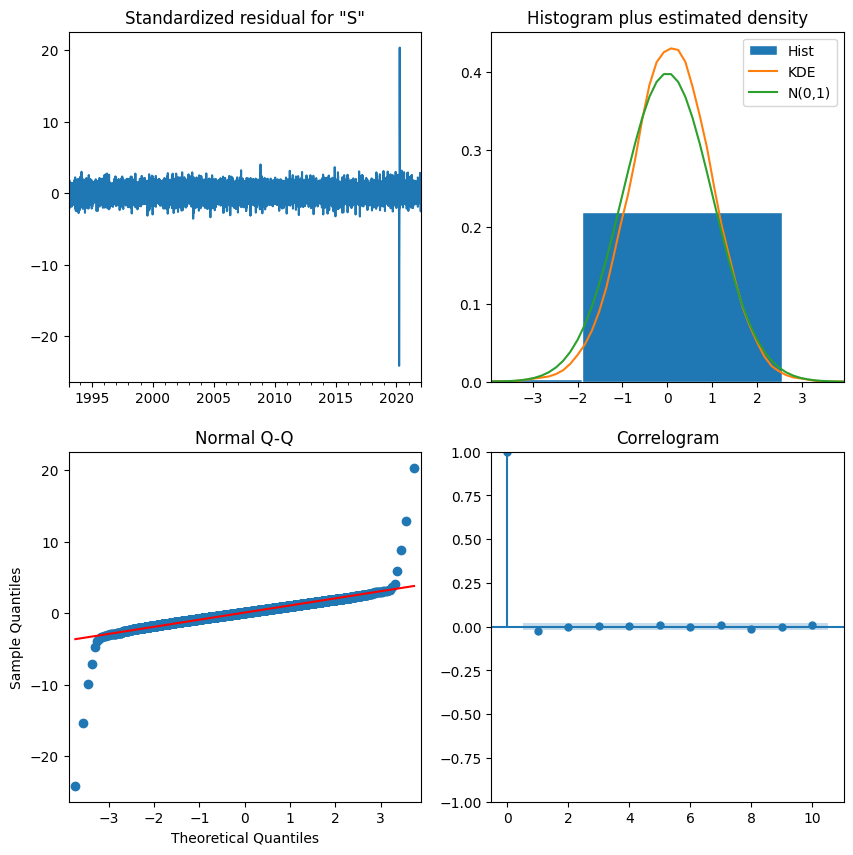

In [ ]:
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

In [ ]:
start_index = 10000

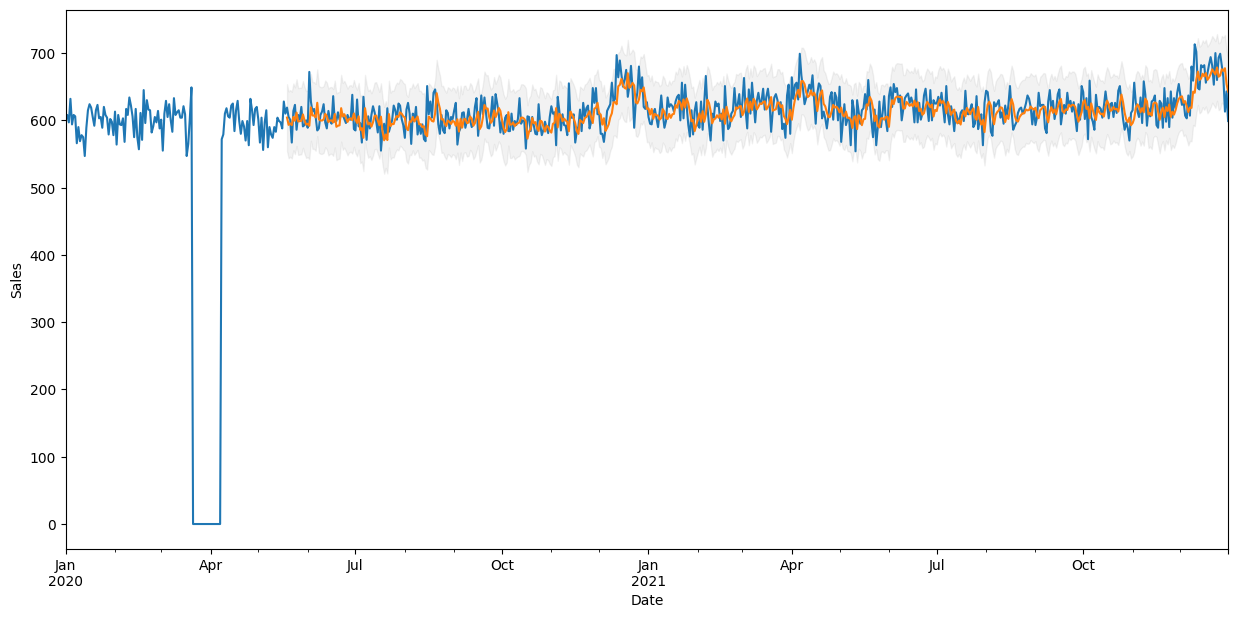

Root Mean Squared Error:  24.0316682250141


In [ ]:
pred = results_sarima.get_prediction(
    start=start_index, dynamic=False)

# Get confidence intervals of forecasts
pred_ci = pred.conf_int()

ax = train_arima['2020':].plot(label="observed", figsize=(15, 7))
pred.predicted_mean.plot(ax=ax, label="One-step ahead Forecast", alpha=1)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color="k", alpha=0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima[start_index:]

# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

## 6. Forecasting Sales <a class="anchor" id="6"></a>

### 6.1. Loading Test Data <a class="anchor" id="6.1"></a>

In [ ]:
test_sales = pd.read_csv('test_egg_sales.csv')

### 6.2. Forecasting sales to test data <a class="anchor" id="6.2"></a>

In [ ]:
test_df = test_sales
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)

# Number of steps to forecast (same as the number of test data points)
forecast_steps = len(test_df)

forecast = results_sarima.get_forecast(steps=forecast_steps)


forecasted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

test_df['Sales'] = forecasted_values

# If you want to see the forecasted values and their confidence intervals
print("Forecasted Values:")
print(forecasted_values)

print("Confidence Intervals:")
print(confidence_intervals)

Forecasted Values:
2022-01-01    626.159227
2022-01-02    622.982424
2022-01-03    623.639674
2022-01-04    623.105367
2022-01-05    623.365587
                 ...    
2022-12-20    604.080651
2022-12-21    598.251756
2022-12-22    596.409337
2022-12-23    594.650379
2022-12-24    603.747649
Freq: D, Name: predicted_mean, Length: 358, dtype: float64
Confidence Intervals:
            lower Sales  upper Sales
2022-01-01   576.529539   675.788916
2022-01-02   570.200607   675.764241
2022-01-03   568.078566   679.200782
2022-01-04   565.071636   681.139098
2022-01-05   563.116835   683.614340
...                 ...          ...
2022-12-20   514.905554   693.255749
2022-12-21   509.071602   687.431910
2022-12-22   507.224466   685.594208
2022-12-23   505.461109   683.839649
2022-12-24   514.554275   692.941022

[358 rows x 2 columns]


In [41]:
test_df.reset_index(inplace=True)

### 6.3. Converting Test Data to CSV <a class="anchor" id="6.3"></a>

In [43]:
test_df.rename(columns={'Date': 'Date;Egg Sales Prediction', 'Sales': 'Egg Sales Prediction'}, inplace=True)

test_df['Date;Egg Sales Prediction'] = test_df['Date;Egg Sales Prediction'].dt.strftime('%Y-%m-%d') + ';' + test_df['Egg Sales Prediction'].astype(str)

test_df.drop(columns=['Egg Sales Prediction'], inplace=True)

test_df.to_csv('./data/test_egg_sales_forecasted.csv', index=False)


## 7. Conclusion <a class="anchor" id="7"></a>

This tast was intersting and I learnt a lot of new things on time series forecasting.<br>
Summary on things I've did in this notebook:
- Data Preprocessing
- Added columns for Year, Month and Day
- Exploratory Data Analysis
- Data Preparation
- Checking for Stationarity using Dicky-Fuller Test
- Making the data stationary
- Grid Search to find the best combination of p, d and q for SARIMAX.
- Model Building and Evaluation
- Forecasting Sales for test data.

## 8. References <a class="anchor" id="8"></a>

These are the references I used for this notebook:
- Krish Naik's Youtube Video: https://youtu.be/2XGSIlgUBDI?feature=shared
- Bisman Preet Singh's Medium Article: https://medium.com/analytics-vidhya/predicting-sales-time-series-analysis-forecasting-with-python-b81d3e8ff03f
- Bisman Preet Singh's Github Repository: https://github.com/bisman16/Kaggle_Rossmann_Store_Sales_Forecasting/tree/master
- Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. https://otexts.com/fpp2.